# Customized RAG Using Retrieve
- **Retrieve API** enables **customization** of the RAG workflow beyond the standard **RetrieveAndGenerate**.
- Provides **flexibility** to modify the workflow after retrieving documents.
- Allows integration with **third-party orchestration frameworks** like **LangChain**.

## **Customized RAG Workflow with Retrieve**
1. **User query** → Converted into **vector embeddings**.
2. **Knowledge base search** → Retrieves relevant document chunks.
3. **Retrieve API returns** retrieved content, metadata, and scores.
4. **Custom workflow execution**:
   - Modify retrieved results.
   - Perform **re-ranking**.
   - Apply **custom filtering**.
5. **Invoke an FM manually** to generate responses.

📌 *Unlike RetrieveAndGenerate, you control the **prompting and response generation**.*

## **Customizing Retrieve using query configurations**
Retrieve API supports **query customization** to optimize retrieval.

### **Input Parameters**
| **Parameter** | **Description** |
|--------------|----------------|
| **Query Text** | The user’s input question. |
| **Next Token** | Used for **pagination** of results. |
| **Total Results** | Number of documents to return (default: 5, max: 100). |
| **Search Type** | Choose **Semantic Search** or **Hybrid Search**. |
| **Filters** | Apply **metadata filters** to refine retrieval results. |

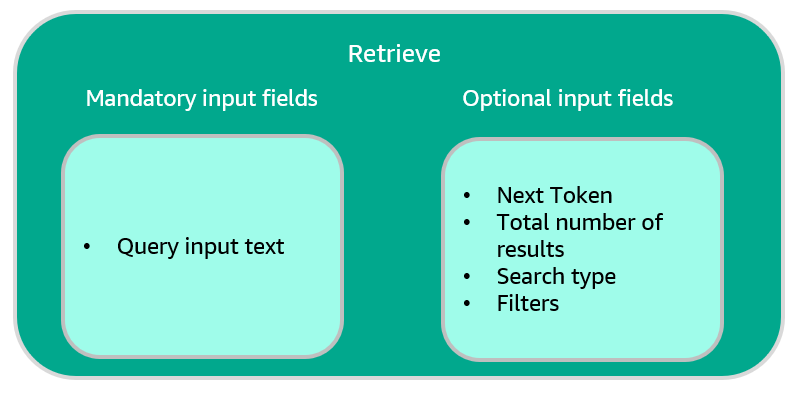

## **RAG filter example with Retrieve using the Python SDK**
### **Step 1: Import libraries and create Amazon Bedrock clients**

In [ ]:
import boto3
import pprint

bedrock_agent_runtime = boto3.client(service_name="bedrock-agent-runtime")
pp = pprint.PrettyPrinter(indent=2)

kb_id = ""  # Use your Knowledge Base ID
model_id = "anthropic.claude-v2"
region_id = "us-east-1"

### **Step 2: Define a custom function to call Retrieve**

In [ ]:
def customRetrieve(query, kbId, yearValue, numberOfResults=5, overrideSearchType='HYBRID'):
    retrievalConfiguration = {
        "vectorSearchConfiguration": {
             "numberOfResults": numberOfResults,
             "overrideSearchType": overrideSearchType,
             "filter": {"equals": {"key": "year", "value": yearValue}}
        }
    }
    return bedrock_agent_runtime.retrieve(
        retrievalQuery={'text': query},
        knowledgeBaseId=kbId,
        retrievalConfiguration=retrievalConfiguration
    )

### **Step 3: Invoke the Retrieve call with the custom function**

In [ ]:
query="Who is Amazon's CEO?"
response = customRetrieve(query, kb_id, yearValue=2020)
pp.pprint(response['retrievalResults'])

# Print response: 
# [ { 'content': { 'text': 'Bezos 57 President, Chief Executive Officer, and '
#                          'Chairman of the Board David H. Clark 48 CEO, '
#                          'Worldwide Consumer Andrew R. Jassy 53 CEO Amazon Web '
#                          'Services ...'},
#     'location': { 's3Location': { 'uri': 's3://amazon10kfiles/Amazon 2020 10K '
#                                          'Annual report.pdf'},
#                   'type': 'S3'},
#     'metadata': { 'x-amz-bedrock-kb-chunk-id': '1%3A0%3AmccQM5EBxA6rr6aO09_T',
#                   'x-amz-bedrock-kb-data-source-id': 'OC4SGRWFRX',
#                   'x-amz-bedrock-kb-source-uri': 's3://amazon10kfiles/Amazon '
#                                                  '2020 10K Annual report.pdf',
#                   'year': 2020.0},
#     'score': 0.6288845},
#   ...]

📌 Changing yearValue to 2023 will return Andy Jassy as CEO.

In [ ]:
response = customRetrieve(query, kb_id, yearValue=2023)
pp.pprint(response['retrievalResults'])

# Print response:
# [ { 'content': { 'text': 'Jassy has served as President and Chief Executive '
#                          'Officer since July 2021, CEO Amazon Web Services '
#                          'from April 2016 until July 2021, and Senior Vice '
#                          'President, Amazon Web Services, from April 2006 '
#                          'until April 2016.   ...'},
#     'location': { 's3Location': { 'uri': 's3://amazon10kfiles/Amazon 2023 10K '
#                                          'Annual report.pdf'},
#                   'type': 'S3'},
#     'metadata': { 'x-amz-bedrock-kb-chunk-id': '1%3A0%3AbscQM5EBxA6rr6aOut6x',
#                   'x-amz-bedrock-kb-data-source-id': 'OC4SGRWFRX',
#                   'x-amz-bedrock-kb-source-uri': 's3://amazon10kfiles/Amazon '
#                                                  '2023 10K Annual report.pdf',
#                   'year': 2023.0},
#     'score': 0.60764116},
#   ]

### **Step 4: Define function to extract chunks from Retrieve response**

In [ ]:
def get_contexts(retrievalResults):
    contexts = []
    for retrievedResult in retrievalResults: 
        contexts.append(retrievedResult['content']['text'])
    return contexts
 
contexts = get_contexts(retrievalResults)

### **Step 5: Call the InvokeModel to generate a response**
- Manually invoke an FM using the retrieved context.
- Example Claude prompt:

In [ ]:
prompt = f"""
Human: You are a strict AI system, and provides answers to questions by using fact based 
and statistical information when possible. 
Use the following pieces of information to provide a concise answer to the question 
enclosed in <question> tags. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{contexts}
</context>
<question>
{query}
</question>
The response should be specific and use statistics or numbers when possible.
Assistant:"""

- Invoke the Foundation Model

In [ ]:
import json

messages=[{ "role":'user', 
"content":[{'type':'text',
'text': prompt.format(contexts, query)}]}]

claude_payload = json.dumps({
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 512,
    "messages": messages,
    "temperature": 0.5,
    "top_p": 1
        }  )

modelId = 'anthropic.claude-v2' 
accept = 'application/json'
contentType = 'application/json'

response = bedrock_client.invoke_model(
    body=claude_payload, 
    modelId=modelId, 
    accept=accept, 
    contentType=contentType)

response_body = json.loads(response.get('body').read())
response_text = response_body.get('content')[0]['text']

## **Using LangChain to use custom prompts to invoke a FM**
### **LangChain libraries setup with custom prompt code snippet.**

In [ ]:
import langchain 
from langchain_aws import ChatBedrock
from langchain.retrievers.bedrock import AmazonKnowledgeBasesRetriever 
from langchain.chains import RetrievalQA 

bedrock_client = boto3.client('bedrock-runtime', region_name = 'us-east-1') 
modelId = 'anthropic.claude-3-sonnet-20240229-v1:0' # change this 
# to use a different version from the model provider 

inference_modifier = { 
    "temperature":0.5, 
    "top_k":250, 
    "top_p":1, 
    "stop_sequences": ["\n\nHuman"] } 

llm = ChatBedrock(model_id = modelId, model_kwargs = inference_modifier)

from langchain.prompts import PromptTemplate 
PROMPT_TEMPLATE = """ 
Human: You are a strict AI system, and provides answers to questions \n
by using fact based and statistical information when possible. \n
Use the following pieces of information to provide a concise answer \n
to the question enclosed in <question> tags. \n
If you don't know the answer, just say that you don't know, don't try to make up an answer.\n
<context> \n
{context} \n
</context> \n
<question> \n
{question} \n
</question> \n
The response should be specific and use statistics or numbers when possible. \n
Assistant:"""

### **LangChain model invoke code snippet with results**

In [ ]:
claude_prompt = PromptTemplate(template=PROMPT_TEMPLATE,
                               input_variables=["context","question"]) 

qa = RetrievalQA.from_chain_type(llm=llm, 
                                 chain_type="stuff", 
                                 retriever=retriever, 
                                 return_source_documents=True, 
                                 chain_type_kwargs={"prompt": claude_prompt} ) 
answer = qa.invoke(query)
pp.pprint(answer)

# Print response:
# { 'query': "Who is Amazon's CEO?",
#   'result': 'According to the information provided, Andrew R. Jassy has served '
#             'as President and Chief Executive Officer of Amazon since July '
#             '2021.',
#    'source_documents': 
#         [ Document(page_content='We promptly make available on this website, free of \
#             charge, the reports that we file or furnish with the Securities and Exchange \
#             Commission (“SEC”), corporate governance information ... ',
#             metadata={'location': 
#                 {'s3Location': {'uri': 's3://amazon10kfiles/Amazon 2021 10K Annual report.pdf'}, 
#                     'type': 'S3'}, 
#                 'score': 0.6369938
#                 }), ...]
# }

## **Custom Re-ranking**

- Re-ranking optimizes retrieved documents before passing them to the FM.

#### Approaches:
Method |	Description <br>
Custom Re-Rank Function |	Apply custom ranking logic to retrieved documents. <br>
Using FM for Re-Ranking |	Use a foundation model to rank retrieved documents. <br>
LangChain Re-Ranking |	Implement re-ranking with Claude 3 Sonnet for document filtering.

### **Using your own custom re-rank function**

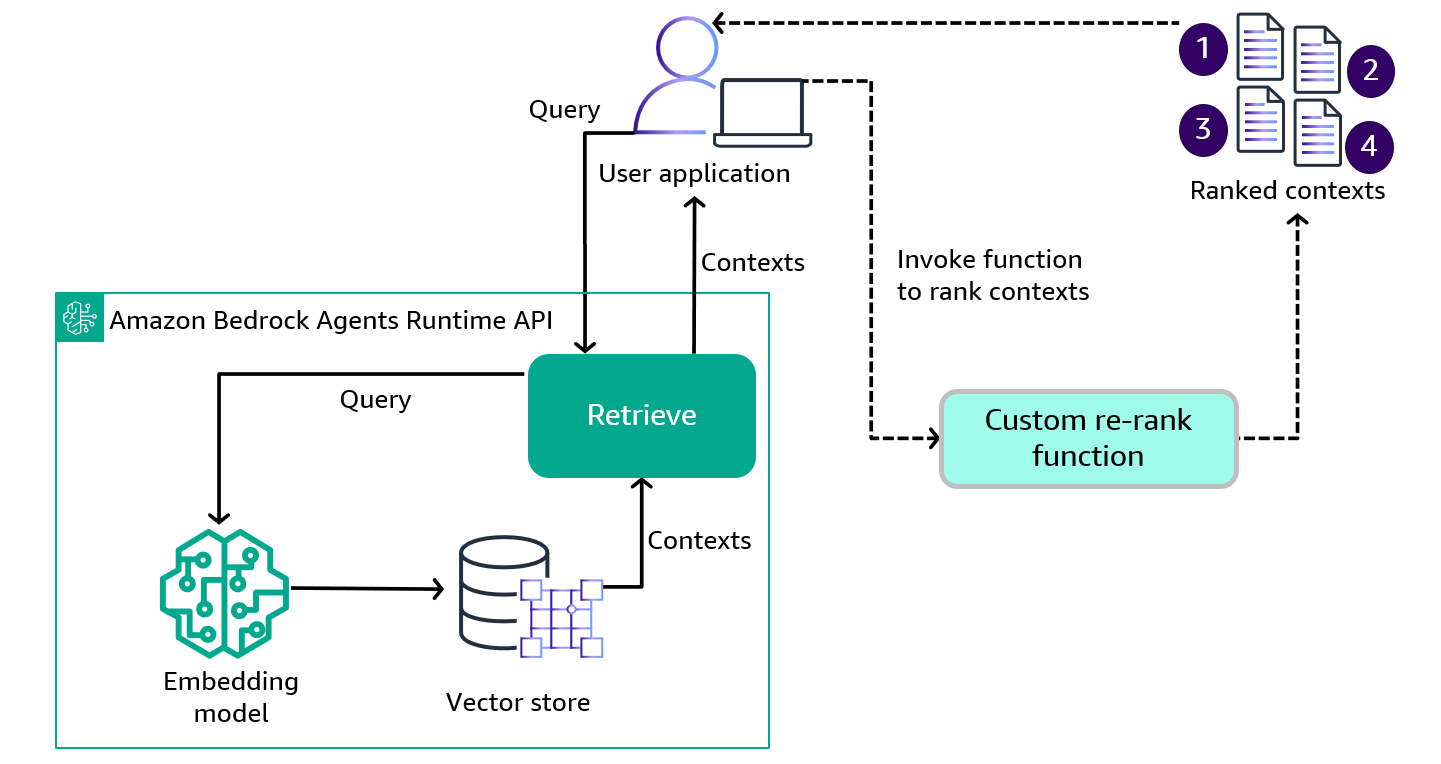

### **Using a FM to re-rank documents**

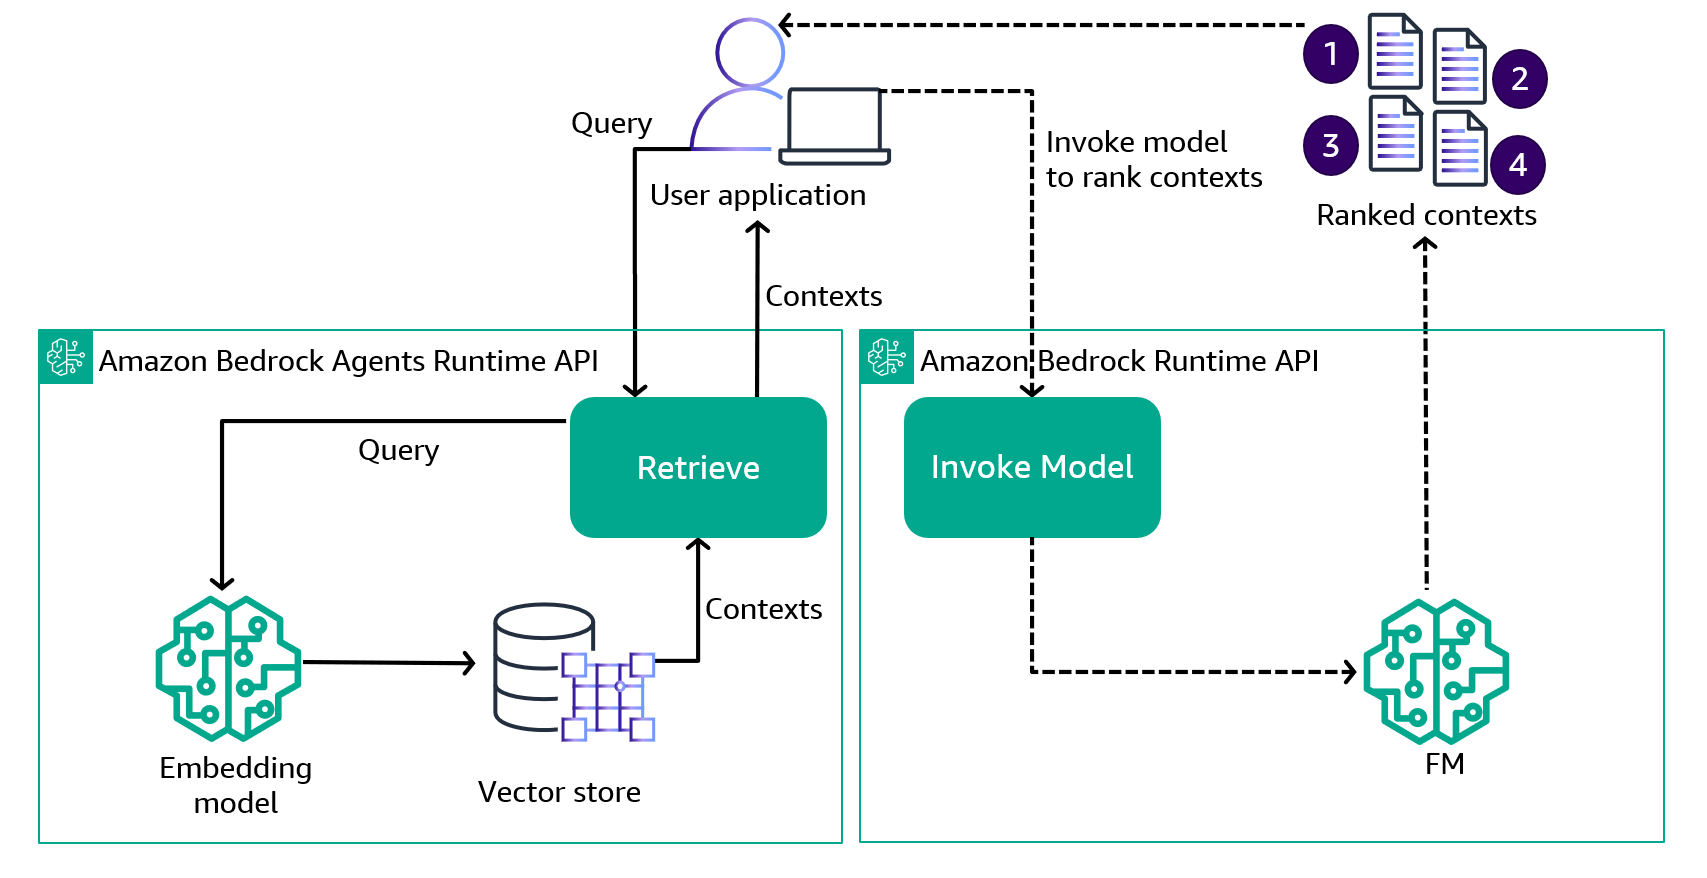

### **Using LangChain to re-rank documents**
- Unranked contexts from retrievalResults code snippet.

In [ ]:
# fetch context from the response 
def get_contexts_for_reranking(retrievalResults): 
    contexts = [] 
    a=1 
    for retrievedResult in retrievalResults: 
        contexts.append(a) 
        contexts.append(retrievedResult['content']['text']) 
        a = a + 1
    return contexts

contexts = get_contexts_for_reranking(retrievalResults) 
pp.pprint(contexts)

# Print response:
# [ 1,
#   'Mr. Selipsky has served as CEO Amazon Web Services since July 2021, Senior '
#   'Vice President, Amazon Web Services from May   2021 until July 2021, '
#   ...,
#   2,
#   'Reynolds. Ms. Reynolds has served as Vice President, Worldwide Controller, '
#   'and Principal Accounting Officer since April 2007. Adam N. Selipsky. Mr. '
#   ...
# ]

- LangChain prompt with context re-ranking instructions code snippet.

In [ ]:
PROMPT_TEMPLATE =""" 
Human: A list of documents is shown below. \n
Each document has a number next to it along with a summary of the document. \n
A question is also provided. Respond with the respective document number. \n
You should consult to answer the question, in order of relevance, as well as the 
relevance score. \n
The relevance score is a number from 1-10 based on how relevant you think the 
document is to the question.\n
Do not include any documents that are not relevant to the question. \n
Mention the documents that are not relevant to the question as not relevant \n
Example format: \n
Document 1:\n<summary of document 1> \n 
Document 2:\n<summary of document 2> \n
...\n\n 
Document 10:\n<summary of document 10> \n
Question: <question> \n
Answer: \n
Doc: 9, Relevance: 7 \n 
Doc: 3, Relevance: 4 \n
Doc: 7, Relevance: 3 \n
Let's try this now: \n
{context_str} \n
Question: {query_str} \n
Assistant: Answer:"""

- LangChain invoke to rank context documents

In [ ]:
query="Who is Amazon's CEO?"
prompt = claude_prompt.format(context_str=contexts,query_str=query)
modelId = 'anthropic.claude-3-sonnet-20240229-v1:0' 

inference_modifier = { 
  "temperature":0.5, 
  "top_k":250, 
  "top_p":1, 
  "stop_sequences": ["\n\nHuman"] } 

chat = ChatBedrock(model_id = modelId, model_kwargs = inference_modifier)
chat.invoke(prompt)

# Print response:
# AIMessage(content='Based on the information provided, the most relevant documents to answer \
#   who is Amazon\'s CEO are:\n\n \
#   Doc: 3, Relevance: 10\nThis document lists the executive officers of Amazon ... \
#   Doc: 4, Relevance: 9\nThis document also lists Andrew R. Jassy as "President ...\
#   Doc: 5, Relevance: 8\nThis document states "Andrew R. Jassy. Mr. Jassy has ... ', 
#   additional_kwargs={'usage': {
#     'prompt_tokens': 5561, 
#     'completion_tokens': 165, 
#     'total_tokens': 5726}, 
#     'stop_reason': 'stop_sequence', 
#     'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, 
#   response_metadata={'usage': {
#   'prompt_tokens': 5561, 
#   'completion_tokens': 165, 
#   'total_tokens': 5726}, 
#   'stop_reason': 'stop_sequence', 
#   'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, 
#   id='run-686f3e9c-936a-413d-a2ec-355ebc47f276-0')